<a href="https://colab.research.google.com/github/imadegunawinangun/PrediksiSuhuDenpasar/blob/main/Prediksi_Suhu_Denpasar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import random
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy import stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [5]:
!git clone https://github.com/imadegunawinangun/PrediksiSuhuDenpasar

fatal: destination path 'PrediksiSuhuDenpasar' already exists and is not an empty directory.


In [6]:
ls PrediksiSuhuDenpasar/

openweatherdata-denpasar-1990-2020.csv      Prediksi_Suhu_Denpasar.ipynb
openweatherdata-denpasar-1990-2020v0.1.csv


In [7]:
data = pd.read_csv('PrediksiSuhuDenpasar/openweatherdata-denpasar-1990-2020.csv')
data.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,rain_6h,rain_12h,rain_24h,rain_today,snow_1h,snow_3h,snow_6h,snow_12h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,631152000,1990-01-01 00:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,25.82,25.82,25.82,1010.0,NaN,NaN,86,1.36,225,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98,500,Rain,light rain,10d
1,631155600,1990-01-01 01:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,26.20,26.20,26.20,1011.0,NaN,NaN,84,2.09,247,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,500,Rain,light rain,10d
2,631159200,1990-01-01 02:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,26.45,26.45,26.45,1011.0,NaN,NaN,84,2.44,262,0.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94,500,Rain,light rain,10d
3,631162800,1990-01-01 03:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,26.80,26.80,26.80,1011.0,NaN,NaN,82,2.29,271,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94,500,Rain,light rain,10d
4,631166400,1990-01-01 04:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,27.04,27.04,27.04,1010.0,NaN,NaN,82,1.71,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,803,Clouds,broken clouds,04d


In [8]:
data.tail()

,dt,dt_iso,timezone,city_name,lat,lon,temp,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,rain_6h,rain_12h,rain_24h,rain_today,snow_1h,snow_3h,snow_6h,snow_12h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
264919,1578423600,2020-01-07 19:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,27.0,27.0,27.0,1007.0,NaN,NaN,94,4.1,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
264920,1578427200,2020-01-07 20:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,27.0,27.0,27.0,1007.0,NaN,NaN,94,5.7,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
264921,1578430800,2020-01-07 21:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,28.0,28.0,28.0,1007.0,NaN,NaN,83,6.7,290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
264922,1578434400,2020-01-07 22:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,28.0,28.0,28.0,1007.0,NaN,NaN,83,6.2,290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n
264923,1578438000,2020-01-07 23:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,28.0,28.0,28.0,1008.0,NaN,NaN,83,5.7,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03d


In [43]:
data = pd.read_csv('PrediksiSuhuDenpasar/openweatherdata-denpasar-1990-2020.csv', 
                   low_memory=False
                   )

data.drop(["dt", "timezone", 'city_name', 'lat', 'lon', 'sea_level','grnd_level', 'rain_1h', 'rain_3h','rain_6h','rain_12h','rain_24h','rain_today','snow_1h','snow_3h','snow_6h','snow_12h','snow_24h','snow_today'], inplace=True, axis=1)
data.drop(['pressure','humidity','wind_speed','wind_deg','clouds_all', 'weather_id', 'weather_main', 'weather_description', 'weather_icon', 'temp_min', 'temp_max'], inplace=True, axis=1)

In [44]:
data

,dt_iso,temp
0,1990-01-01 00:00:00 +0000 UTC,25.82
1,1990-01-01 01:00:00 +0000 UTC,26.20
2,1990-01-01 02:00:00 +0000 UTC,26.45
3,1990-01-01 03:00:00 +0000 UTC,26.80
4,1990-01-01 04:00:00 +0000 UTC,27.04
...,...,...
264919,2020-01-07 19:00:00 +0000 UTC,27.00
264920,2020-01-07 20:00:00 +0000 UTC,27.00
264921,2020-01-07 21:00:00 +0000 UTC,28.00
264922,2020-01-07 22:00:00 +0000 UTC,28.00


In [45]:
data.isnull().sum()


dt_iso    0
temp      0
dtype: int64

In [46]:
data.set_index('dt_iso', inplace=True)

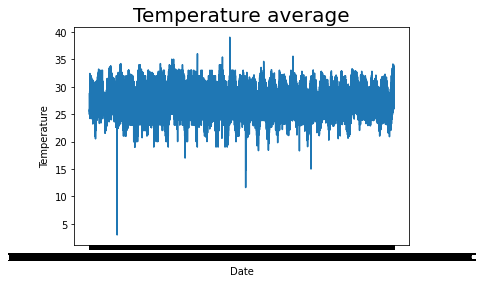

In [13]:
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.plot(data.temp)
plt.title('Temperature average',
          fontsize=20);

In [47]:
data['temp']

dt_iso
1990-01-01 00:00:00 +0000 UTC    25.82
1990-01-01 01:00:00 +0000 UTC    26.20
1990-01-01 02:00:00 +0000 UTC    26.45
1990-01-01 03:00:00 +0000 UTC    26.80
1990-01-01 04:00:00 +0000 UTC    27.04
                                 ...  
2020-01-07 19:00:00 +0000 UTC    27.00
2020-01-07 20:00:00 +0000 UTC    27.00
2020-01-07 21:00:00 +0000 UTC    28.00
2020-01-07 22:00:00 +0000 UTC    28.00
2020-01-07 23:00:00 +0000 UTC    28.00
Name: temp, Length: 264924, dtype: float64

In [48]:
data

,temp
dt_iso,
1990-01-01 00:00:00 +0000 UTC,25.82
1990-01-01 01:00:00 +0000 UTC,26.20
1990-01-01 02:00:00 +0000 UTC,26.45
1990-01-01 03:00:00 +0000 UTC,26.80
1990-01-01 04:00:00 +0000 UTC,27.04
...,...
2020-01-07 19:00:00 +0000 UTC,27.00
2020-01-07 20:00:00 +0000 UTC,27.00
2020-01-07 21:00:00 +0000 UTC,28.00


In [49]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(data)
data

array([[0.63388889],
       [0.64444444],
       [0.65138889],
       ...,
       [0.69444444],
       [0.69444444],
       [0.69444444]])

In [50]:
train = int(len(data)*0.8)
valid = len(data)-train

In [51]:
train_data, valid_data = data[0:train,:], data[train:len(data),:1]

In [52]:
def create_dataset(dataset, time_step=1):
  dataX, dataY = [],[]
  for i in range(len(dataset)-time_step-1):
    _data = dataset[i:(i+time_step), 0]
    dataX.append(_data)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX), np.array(dataY)

In [71]:
time_step = 24

X_train, Y_train = create_dataset(train_data,time_step)
X_valid, Y_valid = create_dataset(valid_data,time_step)

In [72]:
X_train.shape, Y_train.shape

((211914, 24), (211914,))

In [73]:
X_train = X_train.reshape(X_train.shape[0],time_step,1)
X_valid = X_valid.reshape(X_valid.shape[0],time_step,1)

X_train

array([[[0.63388889],
        [0.64444444],
        [0.65138889],
        ...,
        [0.61388889],
        [0.61444444],
        [0.61194444]],

       [[0.64444444],
        [0.65138889],
        [0.66111111],
        ...,
        [0.61444444],
        [0.61194444],
        [0.61527778]],

       [[0.65138889],
        [0.66111111],
        [0.66777778],
        ...,
        [0.61194444],
        [0.61527778],
        [0.61666667]],

       ...,

       [[0.60972222],
        [0.65361111],
        [0.69555556],
        ...,
        [0.64305556],
        [0.63777778],
        [0.65472222]],

       [[0.65361111],
        [0.69555556],
        [0.71472222],
        ...,
        [0.63777778],
        [0.65472222],
        [0.66138889]],

       [[0.69555556],
        [0.71472222],
        [0.73666667],
        ...,
        [0.65472222],
        [0.66138889],
        [0.67777778]]])

In [78]:
class myCallback(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):

    if(logs.get('mae') < 0.01 ):  


      print("\nMAE < 10%")

      self.model.stop_training = True

callbacks90 = myCallback()

In [79]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])



In [82]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(loss='mae',
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(X_train, Y_train, 
                    validation_data=(X_valid, Y_valid),
                    batch_size = 128,
                    epochs=100,
                     callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=5,
                        restore_best_weights=True
                        ), callbacks90]
                        )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
1656/1656 [==============================] - 13s 6ms/step - loss: 0.0177 - mae: 0.0177 - val_loss: 0.0126 - val_mae: 0.0126
Epoch 2/100
1656/1656 [==============================] - 10s 6ms/step - loss: 0.0175 - mae: 0.0175 - val_loss: 0.0117 - val_mae: 0.0117
Epoch 3/100
1656/1656 [==============================] - 10s 6ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0108 - val_mae: 0.0108
Epoch 4/100
1656/1656 [==============================] - 10s 6ms/step - loss: 0.0173 - mae: 0.0173 - val_loss: 0.0111 - val_mae: 0.0111
Epoch 5/100
1656/1656 [==============================] - 10s 6ms/step - loss: 0.0172 - mae: 0.0172 - val_loss: 0.0107 - val_mae: 0.0107
Epoch 6/100
1656/1656 [==============================] - 10s 6ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0117 - val_mae: 0.0117
Epoch 7/100
1656/1656 [==============================] - 10s 6ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0107 - val_mae: 0.0107
Epoch 8/100
1656/1656 [=========================

In [83]:
train_predict=model.predict(X_train)
valid_predict=model.predict(X_valid)

In [85]:
train_predict=scaler.inverse_transform(train_predict)
valid_predict=scaler.inverse_transform(valid_predict)

In [86]:
train_predict

array([[25.19557 ],
       [25.531061],
       [25.772314],
       ...,
       [26.636024],
       [27.203829],
       [28.073635]], dtype=float32)

In [91]:
valid_predict

array([[29.803154],
       [29.532372],
       [29.81817 ],
       ...,
       [27.053062],
       [26.823555],
       [27.882275]], dtype=float32)

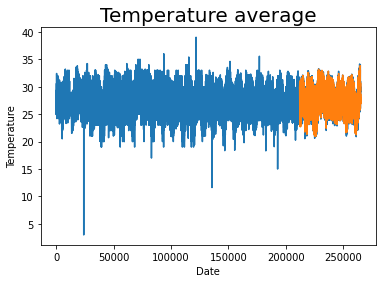

In [93]:
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step,:] = train_predict

testPredictPlot = np.empty_like(data)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+time_step*2+1:len(data)-1,:] = valid_predict

plt.xlabel("Date")
plt.ylabel("Temperature")
plt.plot(scaler.inverse_transform(data))
plt.plot(testPredictPlot)
plt.title('Temperature average',
          fontsize=20);